In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy.stats import linregress
import scipy.stats as stats

In [2]:
population_df = pd.read_csv("CD_population_estimates.csv",index_col="CD_ID")
population_df = population_df.drop(["1990", "1991"],axis=1)

trash_df = pd.read_csv("TonnageClean.csv",index_col=0)

In [3]:
trash_df=trash_df[trash_df["Year"]<2019].drop(["MGP","Paper"],axis=1)

In [4]:
population_df.head(2)

,Borough,CD Number,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
CD_ID,,,,,,,,,,,,,,,,,,,,,
Bronx 1,Bronx,1,77605.860240,78292.870813,78735.102210,79140.123156,79505.86392,80019.936793,80667.604986,81434.029088,...,90183.747541,91497.0,92740.278371,94276.970332,95570.824555,96772.481922,97976.511446,98863.586492,99060.342574,99104.354520
Bronx 2,Bronx,2,40606.750589,41443.115821,42150.799982,42837.751716,43502.19453,44247.204843,45067.123536,45955.837863,...,51487.165274,52246.0,52964.946346,53851.551215,54599.535124,55294.902872,55991.672104,56507.325035,56628.342551,56661.902348


In [5]:
trash_df["CD_ID"]=trash_df["Borough"] + " " + trash_df["CD"].map(str)

In [6]:
trash_df.head(2)

,Month Index,Year/Month,Year,Month,Borough,CD,Refuse,CD_ID
0,23,1993 / 11,1993,11,Manhattan,1,625.2,Manhattan 1
1,45,1995 / 09,1995,9,Manhattan,1,633.1,Manhattan 1


In [7]:
gb = trash_df.groupby(["CD_ID","Year","Borough"])

In [8]:
pctrash_dict = {"CD_ID":[],
                "Borough":[],
               "Year":[],
               "PC_Trash":[]}
for name,frame in gb:
    cd_id = name[0]
    year = str(name[1])
    borough = name[2]
    pctrash_dict["Year"].append(year)
    pctrash_dict["CD_ID"].append(cd_id)
    pctrash_dict["Borough"].append(borough)
    total_refuse = frame["Refuse"].sum()
    population = population_df.loc[cd_id,year]
    pctrash_dict["PC_Trash"].append(total_refuse/population)

In [9]:
PerCapitaTrash = pd.DataFrame(pctrash_dict)

In [59]:
PerCapitaTrash.to_csv("CD_PerCapita_Trash.csv")

In [85]:
analysis_gb = PerCapitaTrash.groupby(["CD_ID","Borough"])
year_gb = PerCapitaTrash.groupby("Year")

In [87]:
analysis_keys = list(analysis_gb.groups.keys())
year_keys = list(year_gb.groups.keys())

In [78]:
def sigma(my_list):
    return np.std(my_list)

def mean(my_list):
    return np.mean(my_list)

def hist_vars(my_list):
    sig = sigma(my_list)
    mu = mean(my_list)
    initial_list = [mu+k*0.5*sig for k in range(-6,6)]
    bins = [min([min(my_list),min(initial_list)])]+initial_list+[max([max(my_list),max(initial_list)])]
    if type(my_list) is list:
        my_list = pd.Series(my_list)
    return [my_list,bins]

<h3> Analysis of the Distribution of Rate of Change in Trash Output Over Community Districts </h3>

<p> In this section, we work to answer the question: "How similar was the rate of change in refuse output between different community districts over time?"</p>

<p> In order to do this, we compute the <a href=https://en.wikipedia.org/wiki/Coefficient_of_variation#Examples_of_misuse> coefficient of variation </a> of the rate of change of per-capita refuse output. We have chosen the coefficient of variation because almost all the rates of change turn out to be negative (see the histogram below).  Therefore, we can consider the mean to represent the size of a typical rate of decrease, and so the ratio of the standard deviation to the mean will allow us to determine the number of times faster or slower a typical community district's trash output varied, compared to the mean. </p>
    
<p> In order to do this, we need to first estimate the rate of change for each community district.  Then, in order to apply the unbiased estimator for coefficient of variation found at the link, we need to verify that the rates of change are normally distributed. </p>

<p> We perform a linear regression for the per-capita refuse output of each community district over time.  We take the slopes of these regression lines (slope_list) to be the rate of change in refuse output for that community district between  1992 and 2018.  We then compute descriptive statistics on these slopes in order to estimate their distribution.  First, using the scipy.stats package, we perform a hypothesis test on the null hypothesis that the slopes are normally distributed.  As the p-value is high (.76) we do not reject the null hypothesis that the rates of change are normally distributed.  Note that this does not mean that the rate of change is guaranteed to be normally distributed, only that we cannot reject the possibility that it is.  </p>

In [111]:
slope_list=[]
for key in analysis_keys:
    df = analysis_gb.get_group(key)
    slope, intercept, r_value, p_value, std_err = linregress(df["Year"].map(int),df["PC_Trash"])
    slope_list.append(slope)

In [116]:
statistic,pvalue = stats.normaltest(slope_list)

print(f"The p-value of the normal distribution hypothesis test is approximately {round(pvalue,2)}.  We cannot reject \
the hypothesis that the rates of change are normally distributed")

The p-value of the normal distribution hypothesis test is approximately 0.77.  We cannot reject the hypothesis that the rates of change are normally distributed


<p> Now we compute the standard deviation (sig) and the mean (mu) of the rates of change.  We then create bins with width equal to half of a standard deviation and plot a histogram.  Once again, the histogram appears to come from a distribution that is approximately normal. </p>

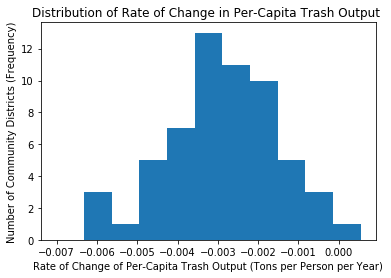

In [79]:
inputs = hist_vars(slope_list)
plt.hist(inputs[0],bins=inputs[1])
plt.xlabel("Rate of Change of Per-Capita Refuse Output (Tons per Person per Year)")
plt.ylabel("Number of Community Districts (Frequency)")
plt.title("Distribution of Rate of Change in Per-Capita Refuse Output ")
plt.show()

<p> Finally, having verified in two ways that it is reasonable to take our data as normally distributed, we estimate the coefficient of variation </p>

In [68]:
coef_var = (1+4/len(slope_list))*(sig/mu)
print(f"The coefficient of variation is estimated to be {coef_var}")

The coefficient of variation is estimated to be -0.507541107521023


<p> The coefficient of variation is approximately -0.5.  The negative sign appears only because the mean is negative.  This means that 68% of community districts saw a rate of decrease in refuse output between 67% and 150% of the mean rate.  Furthermore, we can conclude that 17% of districts decreased their refuse output more than 50% faster than the mean.  Therefore, the variation between rates of decrease in refuse output is significant compared to the average rate of decrease in refuse output. </p>

<h3> Analysis of the Distribution of Per-Capita Trash Output over Community Districts in 1992, 2000, 2010, and 2018</h3>

We will now perform an exploratory analysis on per-capita trash output at four years over the course of the study.  We produce histograms of per-capita refuse output in each year

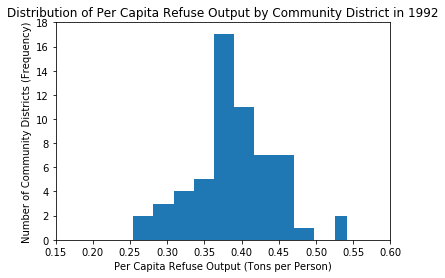

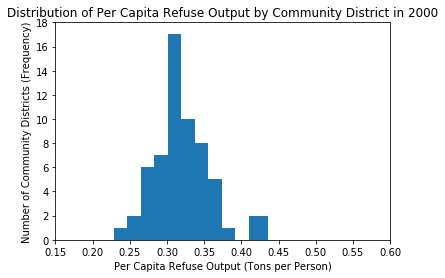

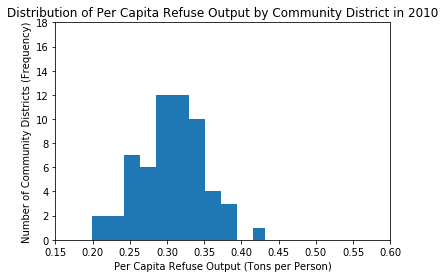

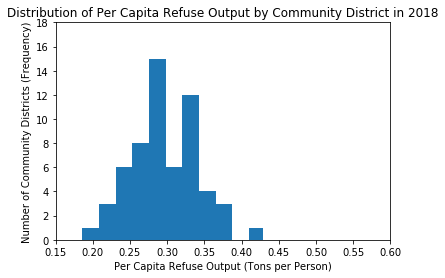

In [118]:
year_list = ["1992","2000","2010","2018"]


for year in year_list:
    df = year_gb.get_group(year)
    PC_Trash = df["PC_Trash"]
    plt.figure()
    plt.hist(hist_vars(PC_Trash)[0],bins=hist_vars(PC_Trash)[1])
    plt.xlim(0.15,0.6)
    plt.ylim(0,18)
    plt.xlabel("Per Capita Refuse Output (Tons per Person)")
    plt.ylabel("Number of Community Districts (Frequency)")
    plt.title(f"Distribution of Per Capita Refuse Output by Community District in {year}")
    plt.show()
    #print(stats.normaltest(PC_Trash))
    

<p>The histograms allow us to see that the distribution of per-capita refuse output is decreasing over time.  This is unsurprising that the same is true of the city as a whole.  We can also see some variation in the spread of the data over time.  This leads to the question: has the spread of per capita trash consumption changed consistently over the 27 years spanned by our data? </p>

<p> To answer this question, we compute the standard deviation of refuse output in each year and make a scatter plot of its change over time. </p>

In [102]:
sigma_list = []
mean_list = []
for year in year_keys:
    PC_Trash = year_gb.get_group(year)["PC_Trash"]
    sigma_list.append(sigma(PC_Trash))
    mean_list.append(mean(PC_Trash))
cv_list = [sigma_list[i]/mean_list[i] for i in range(len(mean_list))]

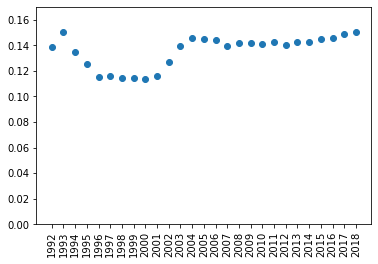

In [109]:
plt.scatter(year_keys,cv_list)
plt.xticks(rotation=90)
plt.ylim(0,0.17)
plt.show()

In [99]:
?plt.xticks